In [23]:
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [24]:
### ==== Read, split, encoding =================
df = pd.read_csv('data_speech_all.csv', sep='\t', encoding='utf-8')
X  = df['segmented']
y  = df['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)


In [25]:
### Encode labels
encoder     = LabelBinarizer()
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc  = encoder.transform(y_test)


In [26]:
### Create sequence
vocabulary_size = 5000

tokenizer       = Tokenizer(num_words= vocabulary_size, char_level = False)
tokenizer.fit_on_texts(X_train)
word_index      = tokenizer.word_index

sequences       = tokenizer.texts_to_sequences(X_train) #mode='tfidf')
X_train_enc     = pad_sequences(sequences, maxlen=30)

seque_test      = tokenizer.texts_to_sequences(X_test) #mode='tfidf')
X_test_enc      = pad_sequences(seque_test, maxlen=30)


In [27]:
def modelquora(pretrained_path="sgns.zhihu.word"):
    dic_quora = {}
    with open(pretrained_path, "r", encoding="utf-8", errors='ignore') as list_words:

        for line_word in list_words:
            if not line_word or line_word.isspace() or line_word.startswith("#"): continue
            list_line = line_word.split()
            dic_quora[list_line[0]] = np.asarray(list_line[1:], dtype='float32')
        #print(self.dic_wiki["grand"].shape)
    return dic_quora

def embeddingMarix(word_index=word_index,vocabulary_size=5000, EMBEDDING_DIM=300):
    dic_quora = modelquora()
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = dic_quora.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [28]:
def create_model(embedding_dim=100,dropout=0.2,recurrent_dropout=0.2,activation='sigmoid',lr=0.01,pretrained=False,trainable=False):
    # default values
    vocabulary_size = 5000
    sentence_len    = 30
    
#     embedding_dim   = 100
#     dropout        = 0.2
#     recurrent_dropout=0.2
#     activation      = 'sigmoid'
#     lr              = 0.001
#     pretrained      = False
#     trainable       = False
    # create model
    model = Sequential()
    if pretrained:
        embedding_matrix = embeddingMarix()
        model.add(Embedding(vocabulary_size, 300, input_length=30, weights=[embedding_matrix], trainable=trainable))
    model.add(Embedding(vocabulary_size, embedding_dim, input_length=30))
    model.add(LSTM(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(8, activation=activation))
    opt = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [29]:
param_grid = dict(
#    embedding_dim=[100,200],
    dropout=[0.0, 0.4],
    recurrent_dropout=[0.0, 0.4],
    activation=['sigmoid','relu','tanh'],
    lr=[0.01,0.1],
#     pretrained=[True, False],
#     trainable=[True,False],
    batch_size=[50,100],
    epochs=[20,40]
    )



In [30]:
model = KerasClassifier(build_fn=create_model)

In [31]:
# model.fit(X_train_enc,y_train_enc)

In [32]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=1)
grid.get_params()

{'cv': 2,
 'error_score': 'raise',
 'estimator': <keras.wrappers.scikit_learn.KerasClassifier at 0x120091390>,
 'estimator__build_fn': <function __main__.create_model>,
 'fit_params': None,
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'activation': ['sigmoid', 'relu', 'tanh'],
  'batch_size': [50, 100],
  'dropout': [0.0, 0.4],
  'epochs': [20, 40],
  'lr': [0.01, 0.1],
  'recurrent_dropout': [0.0, 0.4]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': None,
 'verbose': 1}

In [33]:
grid.fit(X_train_enc,y_train_enc,verbose=0)

Fitting 2 folds for each of 96 candidates, totalling 192 fits
2134/2134 [==============================] - 11s 5ms/step


2134/2134 [==============================] - 16s 7ms/step


2135/2135 [==============================] - 1s 253us/step


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 302.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x120091390>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'dropout': [0.0, 0.4], 'recurrent_dropout': [0.0, 0.4], 'activation': ['sigmoid', 'relu', 'tanh'], 'lr': [0.01, 0.1], 'batch_size': [50, 100], 'epochs': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [34]:
grid.best_score_

0.42047317812302598

In [35]:
grid.best_params_

{'activation': 'sigmoid',
 'batch_size': 100,
 'dropout': 0.4,
 'epochs': 20,
 'lr': 0.01,
 'recurrent_dropout': 0.4}

In [37]:
# from sklearn.externals import joblib
# joblib.dump(grid.best_estimator_, 'lstm-best.pkl')
# joblib.dump(grid.best_estimator_, 'lstm-in-one.pkl', compress = 1)

In [43]:
def GridSearch_table_plot(grid_clf, 
                          param_name,
                          num_results=15,
                          negative=False,
                          graph=True,
                          display_all_params=True):
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd
    
    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))
    
    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()
    
    

best parameters: {'activation': 'sigmoid', 'batch_size': 100, 'dropout': 0.4, 'epochs': 20, 'lr': 0.01, 'recurrent_dropout': 0.4}
best score:      0.42047 (+/-0.00248)
{'activation': 'sigmoid',
 'batch_size': 100,
 'build_fn': <function create_model at 0x11fa62c80>,
 'dropout': 0.4,
 'epochs': 20,
 'lr': 0.01,
 'recurrent_dropout': 0.4}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_batch_size,param_dropout,param_epochs,param_lr,param_recurrent_dropout,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
25,59.199537,29.829307,0.420473,0.996955,sigmoid,100,0.4,20,0.01,0.4,"{'activation': 'sigmoid', 'batch_size': 100, '...",1,0.422951,0.997657,0.417994,0.996253,10.139861,19.639019,0.002478,7.020267e-04
24,50.140847,10.993221,0.417662,0.993675,sigmoid,100,0.4,20,0.01,0,"{'activation': 'sigmoid', 'batch_size': 100, '...",2,0.417799,0.992034,0.417526,0.995316,0.048954,0.261720,0.000136,1.641208e-03
8,53.410478,8.117293,0.415320,0.996252,sigmoid,50,0.4,20,0.01,0,"{'activation': 'sigmoid', 'batch_size': 50, 'd...",3,0.434660,0.997188,0.395970,0.995316,0.024440,0.023046,0.019345,9.361083e-04
29,74.492599,10.534037,0.414149,0.999766,sigmoid,100,0.4,40,0.01,0.4,"{'activation': 'sigmoid', 'batch_size': 100, '...",4,0.414520,1.000000,0.413777,0.999532,0.001281,0.215593,0.000371,2.341918e-04
1,67.854731,15.229871,0.412509,0.996017,sigmoid,50,0,20,0.01,0.4,"{'activation': 'sigmoid', 'batch_size': 50, 'd...",5,0.397658,0.992502,0.427366,0.999532,14.953297,4.008052,0.014854,3.514635e-03
4,82.387936,7.891319,0.410401,0.999766,sigmoid,50,0,40,0.01,0,"{'activation': 'sigmoid', 'batch_size': 50, 'd...",6,0.412178,1.000000,0.408622,0.999532,0.477770,0.074490,0.001778,2.341918e-04
20,66.846424,9.769886,0.409932,0.999532,sigmoid,100,0,40,0.01,0,"{'activation': 'sigmoid', 'batch_size': 100, '...",7,0.406089,1.000000,0.413777,0.999063,0.938925,0.035583,0.003844,4.683838e-04
9,57.442532,8.354141,0.409698,0.995784,sigmoid,50,0.4,20,0.01,0.4,"{'activation': 'sigmoid', 'batch_size': 50, 'd...",8,0.418735,0.995783,0.400656,0.995785,0.756367,0.071454,0.009040,9.881770e-07
13,97.588763,8.604276,0.407590,0.998595,sigmoid,50,0.4,40,0.01,0.4,"{'activation': 'sigmoid', 'batch_size': 50, 'd...",9,0.412646,0.999063,0.402530,0.998126,0.298908,0.479715,0.005058,4.681644e-04
21,73.744987,9.885566,0.406418,0.999766,sigmoid,100,0,40,0.01,0.4,"{'activation': 'sigmoid', 'batch_size': 100, '...",10,0.408431,1.000000,0.404405,0.999532,0.466348,0.760062,0.002013,2.341918e-04


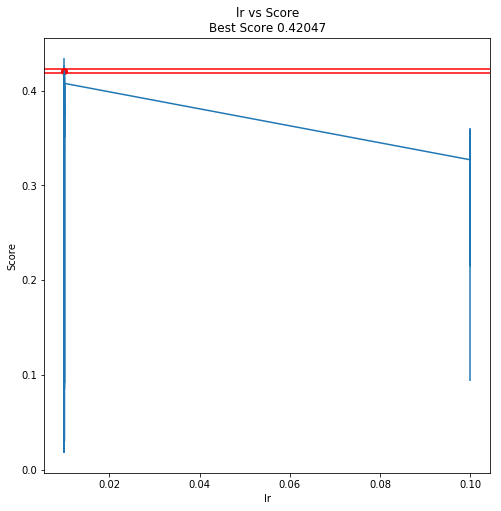

In [44]:
GridSearch_table_plot(grid,"lr")

In [45]:
grid.cv_results_

{'mean_fit_time': array([  55.34098947,   67.85473144,   52.84680963,   52.69815099,
          82.38793647,   91.15544212,   81.18428206,   87.43880105,
          53.41047788,   57.44253159,   54.05827904,   74.84900463,
         369.27514911,   97.58876312,   98.25634086,  105.62724042,
          45.96827602,   45.06535244,   45.39838159,   46.37291241,
          66.8464241 ,   73.74498701,   68.27102542,   70.83160794,
          50.14084744,   59.1995374 ,  161.3592304 ,   49.81654298,
          85.69963551,   74.49259949,   68.66054249,   75.10155582,
          61.94903588,   59.8241626 ,   59.30084312,   62.61161506,
          95.38836682,  102.62444341,   94.43240845,  101.90436459,
          64.81942308,   65.76147258,   62.59382033,   64.82232094,
          99.62737691,  114.49933612,  106.91849506,  139.03078437,
          51.90416241,   52.16989148,   52.85764444,   53.53420973,
          78.36024761,   78.91687512,   72.69461858,   75.64419019,
          51.85106099,   54.778